# Анализ потребления электрической энергии до и после замены счетчика

## Описание проекта

* Прибор учета (далее - ПУ) Потребителя был заменен 10.08.2021г. в связи с подозрением на несанкционированное вмешательство. Взамен снятого прибора установлен аналогичный прибор. Приборы учета позволяют вести почасовый учет электрической энергии. Данные с таких счетчиков могут быть считаны и записаны в базу данных, хранение информации в ней осуществляется независимо от счетчика.

#### Источник данных - таблица значений потребленной электрической энергии за каждый час (время московское) за определенный период времени

#### Цель проекта - определить, имеется ли значимое различие в потреблении электрической энергии до снятия прибора учета и после.

## Содержание 
1. Изучение общей информации
2. Подготовка данных
3. Исследовательский анализ
4. Проверка статистических гипотез
5. Выводы

## Изучение общей информации

In [27]:
# импорт библиотек и извлечение данных
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

try:
    df = pd.read_excel('/Users/hp/Desktop/notebooks/21_1_electry/data_energy.xlsx')
except:
    print('Проверьте правильность указания пути к файлу')

# просмотр общей информации
display(df.head(10), df.tail(10), df.info(), df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5137 entries, 0 to 5136
Data columns (total 2 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   ПКУ БГ
Основные [1 час.]
UTC+3                        5137 non-null   object
 1   Активная энергия, прием
Значения на интервале, кВт*ч  5137 non-null   object
dtypes: object(2)
memory usage: 80.4+ KB


,ПКУ БГ\nОсновные [1 час.]\r\nUTC+3,"Активная энергия, прием\r\nЗначения на интервале, кВт*ч"
0,01.04.2021 01:00:00,22.02
1,01.04.2021 02:00:00,20.76
2,01.04.2021 03:00:00,19.74
3,01.04.2021 04:00:00,18.12
4,01.04.2021 05:00:00,13.68
5,01.04.2021 06:00:00,12.84
6,01.04.2021 07:00:00,19.38
7,01.04.2021 08:00:00,21.6
8,01.04.2021 09:00:00,19.14
9,01.04.2021 10:00:00,16.62


,ПКУ БГ\nОсновные [1 час.]\r\nUTC+3,"Активная энергия, прием\r\nЗначения на интервале, кВт*ч"
5127,31.10.2021 16:00:00,33.84
5128,31.10.2021 17:00:00,28.98
5129,31.10.2021 18:00:00,36.84
5130,31.10.2021 19:00:00,35.28
5131,31.10.2021 20:00:00,33.96
5132,31.10.2021 21:00:00,36.42
5133,31.10.2021 22:00:00,35.16
5134,31.10.2021 23:00:00,36.6
5135,01.11.2021 00:00:00,31.5
5136,Сумма,156357


None

,ПКУ БГ\nОсновные [1 час.]\r\nUTC+3,"Активная энергия, прием\r\nЗначения на интервале, кВт*ч"
count,5137,5137.00
unique,5137,657.00
top,23.08.2021 19:00:00,31.56
freq,1,32.00


#### *Для анализа использованы данные из ПО АРМ "Энергосфера", сохраненные за период с 01.04.2021г. по 01.11.2021г. (полугодие)*

## Подготовка данных

Исходные данные - таблица, состоящая из 5137 строк, данные объектового типа (строки). Данные собраны автоматизированно. Для целей анализа необходимо преобразовать данные к соответствующим типам: дата/время (datetime) и числовой формат (float)

In [28]:
df.columns # выведем наименования столбцов

Index(['ПКУ БГ\nОсновные [1 час.]\r\nUTC+3', 'Активная энергия, прием\r\nЗначения на интервале, кВт*ч'], dtype='object')

In [37]:
# переименование столбцов
df.rename(columns={'ПКУ БГ\nОсновные [1 час.]\r\nUTC+3':'Дата', 'Активная энергия, прием\r\nЗначения на интервале, кВт*ч':'Активная энергия, кВтч'}, inplace=True)

# удаление последней строки
df = df.drop(df[len(df)-1:].index)

# изменение формата данных (дата/время)
df['Дата'] = pd.to_datetime(df['Дата'],dayfirst=True)

df[(df['Активная энергия, кВтч'] == '-')]
# В данных есть пропуски, промаркированные "-" заменим их 0
# обнаружено при попытке изменения формата
df['Активная энергия, кВтч'] = df['Активная энергия, кВтч'].replace({'-':'0'})

# Преобразуем тип данных для вычислений
df['Активная энергия, кВтч'] = df['Активная энергия, кВтч'].astype(float)

# Дополнительные столбцы
df['День'] = pd.DatetimeIndex(df['Дата']).day
df['Месяц'] = pd.DatetimeIndex(df['Дата']).month

df['день2'] = df['Дата'].dt.strftime('%d %b %Y')

## Исследовательский анализ

Оценим изменение потребления электрической энергии за полгода. Построим график, на котором отметим дату замены ПУ.

In [38]:
# создаем таблицу для вывода графика
df1 = df.pivot_table(index = ['Месяц','День', 'день2'], values = 'Активная энергия, кВтч', aggfunc = 'sum').\
reset_index()
a = df1.query('Месяц == 8 & День == 10')
df2 = df1.set_index('день2', drop=True)
df2

,Месяц,День,"Активная энергия, кВтч"
день2,,,
01 Apr 2021,4,1,424.62
02 Apr 2021,4,2,456.78
03 Apr 2021,4,3,370.38
04 Apr 2021,4,4,385.80
05 Apr 2021,4,5,403.38
...,...,...,...
28 Oct 2021,10,28,833.70
29 Oct 2021,10,29,855.48
30 Oct 2021,10,30,804.00


In [39]:
df2 = df1.set_index('день2', drop=True)
df2

,Месяц,День,"Активная энергия, кВтч"
день2,,,
01 Apr 2021,4,1,424.62
02 Apr 2021,4,2,456.78
03 Apr 2021,4,3,370.38
04 Apr 2021,4,4,385.80
05 Apr 2021,4,5,403.38
...,...,...,...
28 Oct 2021,10,28,833.70
29 Oct 2021,10,29,855.48
30 Oct 2021,10,30,804.00


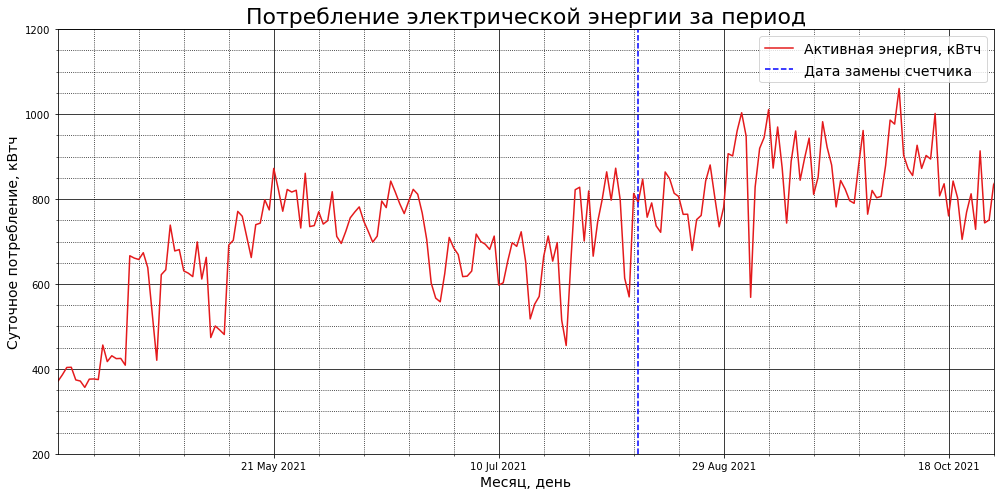

In [40]:
fig, ax = plt.subplots(figsize=(14, 7))
#one_tick = fig.axes[0].yaxis.get_major_ticks()[0]
df2['Активная энергия, кВтч'].plot(colormap='Set1')


ax.set_title('Потребление электрической энергии за период', fontsize=22)
ax.legend(loc='upper left')
ax.set_ylabel('Cуточное потребление, кВтч', fontsize=14)
ax.set_xlabel('Месяц, день', fontsize=14)
fig.tight_layout()
ax.set_xlim(2, 210)
ax.set_ylim(200, 1200)
ax.grid(True)
ax.minorticks_on()

ax.grid(which='major',
        color = 'k', 
        linewidth = 0.75)

#  Определяем внешний вид линий вспомогательной
#  сетки:
ax.grid(which='minor', 
        color = 'k', 
        linestyle = ':')
ax.axvline(a.index, label = 'Дата замены счетчика', color='b', linestyle='--')

plt.legend(fontsize=14)
plt.show()

В начале периода потребление электроэнергии значительно ниже. Вероятно, рост потребления в апреле связан с установкой оборудования и вывода предприятия на производственную мощность.

На величину потребления электроэнергии, как правило, влияют различные факторы: наличие электрообогрева, характер производственного цикла. Сравним значения электроэнергии заразличные периоды. Например, за месяц до замены счетчика и через месяц после. Для этого сформируем две выборки и оценим плотность распределения значений в них.

In [41]:
# зоздаем срез в зависимости от даты
df_before = df[(df['Дата'] < '2021-08-10') & (df['Дата'] >= '2021-07-10')]
df_after = df[(df['Дата'] > '2021-08-10') & (df['Дата'] <= '2021-09-10')]

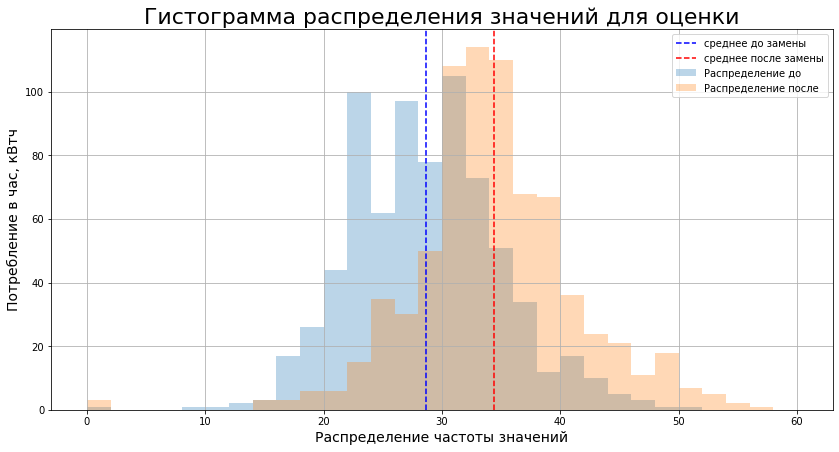

In [42]:
#средние значения в выборках:
d_bef = df_before['Активная энергия, кВтч'].mean()
d_aft = df_after['Активная энергия, кВтч'].mean()

#график
fig, ax = plt.subplots(figsize=(14, 7))
ax.grid(True)
ax = plt.hist(x = df_before['Активная энергия, кВтч'], bins=30, range = (0,60), label  = 'Распределение до', alpha = 0.3)
plt.hist(x = df_after['Активная энергия, кВтч'],  bins=30, range = (0,60), label = 'Распределение после', alpha = 0.3)

plt.xlabel('Распределение частоты значений', fontsize=14)
plt.title('Гистограмма распределения значений для оценки', fontsize=22)
plt.ylabel('Потребление в час, кВтч', fontsize=14)


plt.axvline(d_bef,label = 'среднее до замены', color='b', linestyle='--') 
plt.axvline(d_aft,label = 'среднее после замены', color='r', linestyle='--') 
plt.legend();

In [43]:
print('Среднее до:', d_bef)
print('Среднее после:', d_aft)

Среднее до: 28.644354838709713
Среднее после: 34.423709677419346


Плотности распределения близки к нормальным, однако, распределение до замены менее выражено.
Средние значения часового потребления за месяц различны: после замены счетчика, потребление выросло.
Целесообразно провести проверку статистической гипотезы на равенство средних непараметрическим критерием Манна-Уитни. 

## Проверка статистических гипотез

Для проверки этой гипотезы необходимо сравнить средние значения двух совокупностей: срезы данных в зависимости от используемого прибора учета

Сравниваются две выборки между собой: за месяц до замены и через месяц после замены, дата замены счетчика ни в одной выборке не учитывается.

Сформулируем нулевую и альтернативную гипотезы:

**H0: среднее потребление электроэнергии, учитываемое снятым счетчиком равно среднему потреблению электроэнергии, учитываемому установленным счетчиком.**

**H1: среднее потребление электроэнергии, учитываемое снятым и установленным счетчиком отличается.**

In [44]:
# задаем функцию, параметрами которой будут уровень значимости и две выборки
def check_hypotises_mu(alpha, val1, val2):
 
    results = st.mannwhitneyu(val1, val2)
    p_value = results[1]
    #print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: Различие средних статистически значимо")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: Различие средних статистически незначимо") 
    
    print("p-значение: ","{0:.3f}".format(p_value))

Проверим выборки за месяц:

In [45]:
check_hypotises_mu(alpha = 0.05, val1 = df_before['Активная энергия, кВтч'],\
                   val2 = df_after['Активная энергия, кВтч'])

Отвергаем нулевую гипотезу: Различие средних статистически значимо
p-значение:  0.000


**Различие среднего значения потребленияэлектроэнергии до замены (28,6 кВтч) и среднего значения потребления электроэнергии после замены (34,4 кВтч) статистически значимо различны**

Изменим размер проверяемых выборок, и проверим различия в учете потребления электроэнергии за неделю до и за неделю после замены. На графике потребления эти изменения сложно оценить визуально за такой непродолжительный период.

Сформируем две выборки. Дату замены прибора из обеих выборок также исключаем.

In [46]:
df_before_7 = df[(df['Дата'] < '2021-08-10') & (df['Дата'] >= '2021-08-03')]
df_after_7 = df[(df['Дата'] > '2021-08-10') & (df['Дата'] <= '2021-08-17')]

print('Среднее значение до замены:', df_before_7['Активная энергия, кВтч'].mean())
print('Среднее значение после замены:',df_after_7['Активная энергия, кВтч'].mean())

Среднее значение до замены: 31.72214285714286
Среднее значение после замены: 32.8282142857143


Проверим те же гипотезы на семидневных выборках, на уровне значимости = 0,05

In [47]:
check_hypotises_mu(alpha = 0.05, val1 = df_before_7['Активная энергия, кВтч'],\
                   val2 = df_after_7['Активная энергия, кВтч'])

Отвергаем нулевую гипотезу: Различие средних статистически значимо
p-значение:  0.045


**Таким образом, при выбранном уровне значимости мы также получили статистически значимое различие средних значений: среднее значение потребления электроэнергии после замены прибора выше**

## Вывод. 

**Среднечасовое потребление электрической энергии потребителем до замены прибора учета и после замены прибора учета статистически различны. Проведение статистического теста на недельных выборках свидетельствует о том, что вновь установленный прибор учитывает учитывает большее количество электроэнергии.**

 *По результатам технического исследования снятого прибора учета заводом-изготовителем установлено наличие непредусмотренного заводом устройства. Данное устройство используется для искажения учитываемой счетчиком электроэнергии (потребление уменьшается дистанционно). Таким образом, установлено вмешательство потреблителя в учет электроэнергии.*